# Visual SLAM II

In this SLAM recitation, we will implement a visual SLAM system that uses an OpenCV frontend, a GTSAM backend, and a loop closure module based on a bag-of-words approach. Our objective is to test the system using the abandoned_factory P006 sequence from the TartanAir dataset. To get started, we'll need to access the camera intrinsics, extrinsics, and data format information, which can be found here: https://github.com/castacks/tartanair_tools/blob/master/data_type.md.

In this notebook, we will walk through the implementation of the camera model, backend, and loop closure step-by-step, while visualizing the output of each step. Specifically, we will cover the following topics:

- Calculating global XYZ positions for the landmarks
- Optimize the trajectory with projection factors in GTSAM
- Improve estimated trajectory by adding loop closure

## I. Dependency


### 1. Install Python libraries

In [1]:
# install the minslam package in “editable” mode
# !pip install -e ..

# install other libraries
# !pip install numpy spatialmath-python opencv-python matplotlib gtsam ipympl

# use conda to install gtsam if pip fails
# !conda install gtsam

### 2. Download dataset
Please download [abadoned_factory P006 dataset](https://drive.google.com/file/d/1Q_fSI0U-IMfv90lyE1Uh78KV2QJheHbv/view?usp=share_link) and extract it to a folder named "data".

In [3]:
import os

# test if we can find the dataset
dataset_folder = '../data/'
print('Check if the data folder exists:',os.path.exists(dataset_folder))

Check if the data folder exists: True


### 3. Import libraries

In [4]:
# this block should run without error

# change the perspective of 3d plots with this command
%matplotlib widget

# frontend
import numpy as np
from spatialmath import *
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm

# backend
import gtsam
from gtsam.symbol_shorthand import L, X

# our slam implementation
from minslam.data_loader import TartanAirLoader
from minslam.frontend import Frontend
from minslam.params import Params
from minslam.backend import Backend
from minslam.camera import PinholeCamera

### 4. Load images and trajectory

In [5]:
traj_filename = 'pose_left.txt'
traj_path = os.path.join(dataset_folder, traj_filename)
print('Loading trajectory from ', traj_path)

# load a trajectory
dataset_folder = '../data/P006'
dataset = TartanAirLoader(dataset_folder)
dataset.load_ground_truth()
dataset.set_odometry(dataset.gt)

Loading trajectory from  ../data/pose_left.txt


## II. Frontend

We will build a function that tries to find the next keyframe and return it.

In [6]:
# clear previous states
params = Params('../params/tartanair.yaml')
frontend = Frontend(params)

# run the whole pipeline once
def run_frontend_once(frontend):
    pose = dataset.read_current_odometry()
    while not frontend.keyframe_selection(pose):
        if not dataset.load_next_frame():
            break
        pose = dataset.read_current_odometry()
    color, depth = dataset.read_current_rgbd()
    frontend.add_keyframe(pose, color, depth)
    print(f'--- Added keyframe {frontend.frame_id} (seq id: {dataset.curr_index}) ---')
    if frontend.frame_id > 0:
        frontend.match_features()
        frontend.eliminate_outliers()
    more_points_n = params['frontend']['feature']['number']-len(frontend.curr_frame.points)
    print('current point number:', len(frontend.curr_frame.points))
    if more_points_n>0:
        print('extracting more features:', more_points_n)
        frontend.extract_features(more_points_n, append_mode=True)
    frontend.assign_global_id()
    # frontend.plot_matches(with_global_id=True)
    return frontend.curr_frame

## III. Camera

In this section, we will learn what is pinhole camera model and how to use it to calculate the XYZ global position of the landmarks.

### 1. Pinhole camera model

To help us understand the pinhole camera model, we recommend reviewing two resources:

- [CS231A Course Notes 1: Camera Models](https://web.stanford.edu/class/cs231a/course_notes/01-camera-models.pdf): how to derive the pinhole camera model.
- [OpenCV - Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html): how a OpenCV library models and implements pinhole camera.

These resources should provide a good foundation for understanding the principles behind the pinhole camera model and how it is implemented in practice.

In [6]:
camera = PinholeCamera(params)

### 2. Calculate the global XYZ positions of landmarks

Next, we will use the camera intrinsics and the pixel coordinates of each feature to calculate its 3D position in the camera frame. We will then use the camera poses and the 3D positions of the features to calculate the global XYZ positions of the landmarks.

--- Added keyframe 0 (seq id: 270) ---
current point number: 0
extracting more features: 50


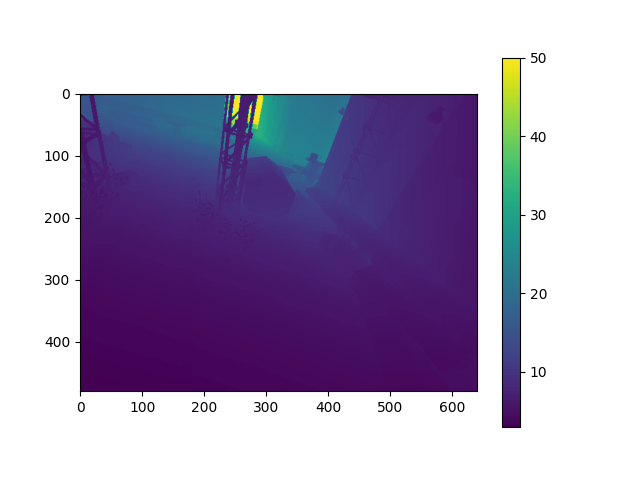

In [7]:
dataset.set_curr_index(270)
frontend_frame = run_frontend_once(frontend)
depth = frontend_frame.depth
plt.clf()
im = plt.imshow(depth.clip(0,50))
plt.colorbar(im)
plt.show()

To calculate the global positions, we will first use the camera model to get the XYZ position of the landmarks in the camera frame (x->right, y->downward, z->forward). The point cloud below is generated by evenly sampled points from the depth image.

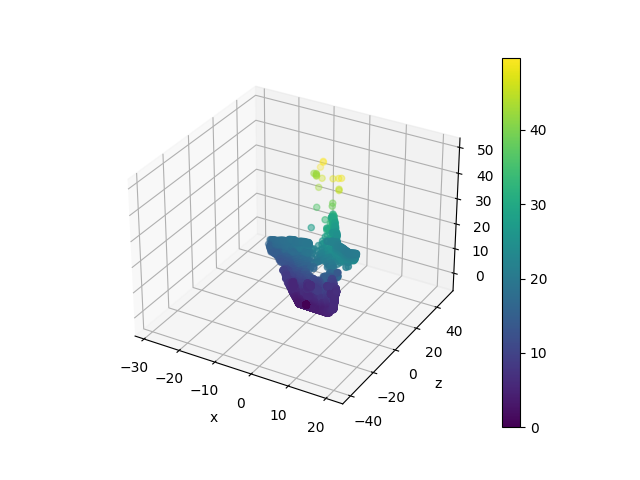

In [8]:
points_xyz = np.zeros((64*48*4+1, 3)) # add one row for the origin
index = 0
for i in range(0,640,5):
    for j in range(0,480,5):
        point = np.array([i,j])
        depth = frontend_frame.depth[int(point[1]), int(point[0])]
        # skip points with large depth just for better visualization
        if depth>50:
            continue
        ######### use the camera model here #########
        points_xyz[index] = camera.back_project2(point[0], point[1], depth).flatten()
        #############################################
        index += 1
ax = plt.figure().add_subplot(projection='3d')
# modify the axis to better visualize the point cloud
sc = ax.scatter(points_xyz[:,0], points_xyz[:,2], points_xyz[:,1]*-1, 'o', c=points_xyz[:,2])
plt.colorbar(sc)
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')

# Create cubic bounding box to simulate equal aspect ratio
# ref: https://stackoverflow.com/a/13701747
X_data,Y_data,Z_data = points_xyz[:,0], points_xyz[:,1], points_xyz[:,2]
max_range = np.array([X_data.max()-X_data.min(), Y_data.max()-Y_data.min(), Z_data.max()-Z_data.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X_data.max()+X_data.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y_data.max()+Y_data.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z_data.max()+Z_data.min())
for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

Then, we will transform the points into the body frame defined by the dataset (see [here](https://github.com/castacks/tartanair_tools/blob/master/data_type.md)). It is defined as: x->forward, y->right, z->downward. Finally, we transform these points using the odometry pose to get the position in world frame.

--- Added keyframe 1 (seq id: 100) ---
current point number: 22
extracting more features: 278


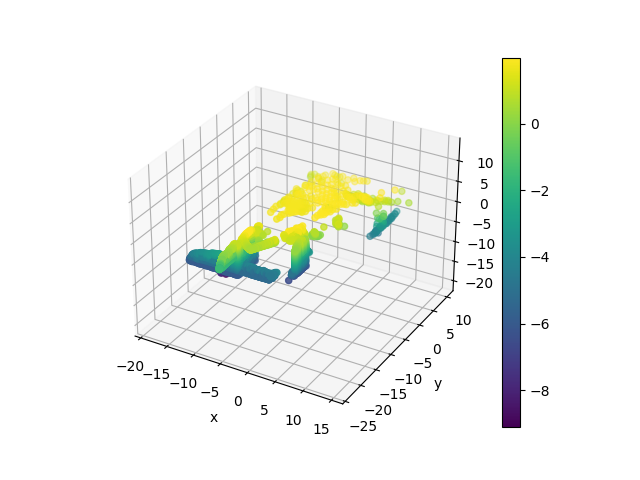

In [9]:
dataset.set_curr_index(100)
frontend_frame = run_frontend_once(frontend)
points_xyz = np.zeros((64*48*4+1, 3)) # add one row for the origin
index = 0
for i in range(0,640,5):
    for j in range(0,480,5):
        point = np.array([i,j])
        depth = frontend_frame.depth[int(point[1]), int(point[0])]
        # skip points with large depth just for better visualization
        if depth>30:
            continue
        ######### we now transform these points into world frame #########
        points_xyz[index] = camera.back_project(point[0], point[1], depth, frontend_frame.odom_pose).flatten()
        ##################################################################
        index += 1
ax = plt.figure().add_subplot(projection='3d')
sc = ax.scatter(points_xyz[:,0], points_xyz[:,1], points_xyz[:,2], 'o', c=points_xyz[:,2])
plt.colorbar(sc)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Create cubic bounding box to simulate equal aspect ratio
# ref: https://stackoverflow.com/a/13701747
X_data,Y_data,Z_data = points_xyz[:,0], points_xyz[:,1], points_xyz[:,2]
max_range = np.array([X_data.max()-X_data.min(), Y_data.max()-Y_data.min(), Z_data.max()-Z_data.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X_data.max()+X_data.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y_data.max()+Y_data.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z_data.max()+Z_data.min())
for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

In real backend, we will only use the detected sparse feature, and they look like this:

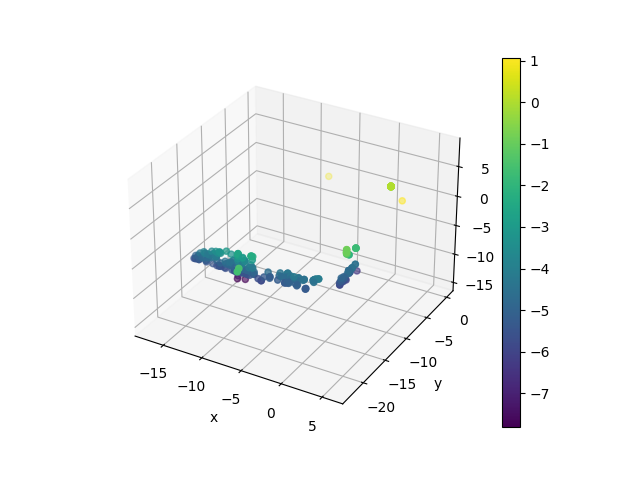

In [10]:
points_xyz = np.zeros((len(frontend_frame.points), 3))
for i, point in enumerate(frontend_frame.points):
    depth = frontend_frame.depth[int(point[1]), int(point[0])]
    # skip points with large depth just for better visualization
    if depth>30:
        continue
    ######### use the camera model here #########
    global_xyz = camera.back_project(point[0], point[1], depth, frontend_frame.odom_pose)
    #############################################
    points_xyz[i] = global_xyz.flatten()

ax = plt.figure().add_subplot(projection='3d')
sc = ax.scatter(points_xyz[:,0], points_xyz[:,1], points_xyz[:,2], 'o', c=points_xyz[:,2])
plt.colorbar(sc)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Create cubic bounding box to simulate equal aspect ratio
# ref: https://stackoverflow.com/a/13701747
X_data,Y_data,Z_data = points_xyz[:,0], points_xyz[:,1], points_xyz[:,2]
max_range = np.array([X_data.max()-X_data.min(), Y_data.max()-Y_data.min(), Z_data.max()-Z_data.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X_data.max()+X_data.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y_data.max()+Y_data.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z_data.max()+Z_data.min())
for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

## IV. Backend

In this section, we will use GTSAM library to optimize the trajectory using the measurements obtained from the frontend. To incorporate the camera pose and landmark positions in the optimization process, we will use the projection factor in GTSAM.

--- Added keyframe 0 (seq id: 50) ---
current point number: 0
extracting more features: 300
add 300 measurements to backend
add prior factor for frame  0
--- Added keyframe 1 (seq id: 51) ---
current point number: 153
extracting more features: 147
add 181 measurements to backend
--- Added keyframe 2 (seq id: 52) ---
current point number: 121
extracting more features: 179
add 180 measurements to backend
--- Added keyframe 3 (seq id: 53) ---
current point number: 225
extracting more features: 75
add 91 measurements to backend
--- Added keyframe 4 (seq id: 54) ---
current point number: 200
extracting more features: 100
add 131 measurements to backend
--- Added keyframe 5 (seq id: 55) ---
current point number: 182
extracting more features: 118
add 119 measurements to backend
--- Added keyframe 6 (seq id: 56) ---
current point number: 181
extracting more features: 119
add 120 measurements to backend
--- Added keyframe 7 (seq id: 57) ---
current point number: 194
extracting more features: 10

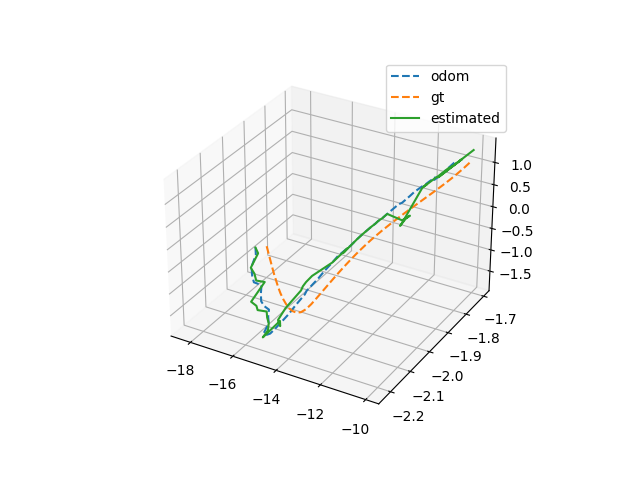

In [12]:
# load the dataset
params = Params('../params/tartanair.yaml')
frontend = Frontend(params)
backend = Backend(params)
dataset = TartanAirLoader('../data/P006/')
dataset.set_curr_index(50)
n_keyframes = 50

# read the ground truth and odometry
dataset.load_ground_truth()
gt_poses = dataset.gt
odom_poses = dataset.add_noise(gt_poses, [1e-4, 3e-4], [1e-3, 1e-3], seed=100)
dataset.set_odometry(odom_poses)

# for plotting
gt_traj = np.zeros((n_keyframes, 3))
odom_traj = np.zeros((n_keyframes, 3))

# run the frontend and backend
for i in range(n_keyframes):
    # get results from frontend
    frontend_frame = run_frontend_once(frontend)
    gt_traj[i] = dataset.read_current_ground_truth().t
    odom_traj[i] = dataset.read_current_odometry().t
    measurements = []
    frame_id = frontend_frame.frame_id
    count = 0
    for landmark in frontend_frame.landmarks:
        global_id = landmark.global_id
        measurement = landmark.measurements[frame_id] # u, v, depth
        if not landmark.is_outlier_gt(frontend, 0.01):
            count += 1
            measurements.append((global_id, *measurement))
    print(f'add {count} measurements to backend')
    # add measurements to backend
    backend.add_keyframe(frame_id, frontend_frame.odom_pose, measurements)
# optimize the backend
backend.optimize(optimizer='LM')
backend_estimate = backend.current_estimate
estimated_traj = gtsam.utilities.extractPose3(backend_estimate)[:, -3:]

# plot the results
plt.clf()
ax = plt.figure().add_subplot(projection='3d')
ax.plot(odom_traj[:n_keyframes,0],odom_traj[:n_keyframes,1],odom_traj[:n_keyframes,2], '--', label='odom')
ax.plot(gt_traj[:n_keyframes,0],gt_traj[:n_keyframes,1],gt_traj[:n_keyframes,2], '--', label='gt')
ax.plot(estimated_traj[:n_keyframes,0],estimated_traj[:n_keyframes,1], estimated_traj[:n_keyframes,2], label='estimated')
ax.legend()

## V. Loop Closure

In this section, we will explore the concept of loop closure by building a toy example.

We will be using the visual bag of word method, similar to ORB-SLAM2, to detect a loop in the trajectory. However, since there are no well-built visual bag of word libraries in Python, we will assume that we have successfully found a loop. To have a more complete implementation, you can refer to [nicolov/simple_slam_loop_closure](https://github.com/nicolov/simple_slam_loop_closure/blob/master/src/new_college.cpp). Additionally, we will build a pose graph in this example to simplify the calculation and demonstrate how the loop closure affects the estimated trajectory.

### 1. The loop

First, we will visualize the trajectory which includes a loop. It's important to note that a loop doesn't necessarily mean the robot comes back to the exact same place, but rather it should be near a place it visited before so that a relative pose between two frames can be found.

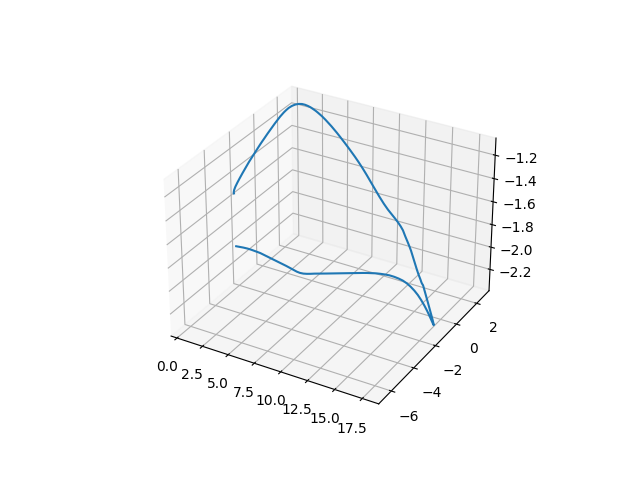

In [12]:
# load seq P006
dataset = TartanAirLoader('../data/P006/')
gt_poses = dataset._load_traj('tum', traj_filename, add_timestamps=True)
gt_traj = np.array([x.t for x in gt_poses])

# set the start and end frame for the sequence
seq_start = 185
seq_end = 518
n_frames = seq_end - seq_start

# draw the loop
plt.clf()
ax = plt.figure().add_subplot(projection='3d')
ax.plot(gt_traj[seq_start:seq_end,0], gt_traj[seq_start:seq_end,1], gt_traj[seq_start:seq_end,2], label='gt')
plt.show()

The start and end frame of the loop should have a similar viewpoint and share a significant number of visual features:

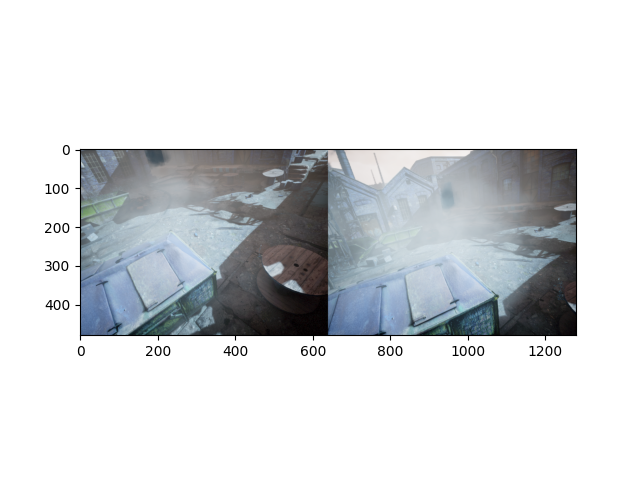

In [104]:
dataset.set_curr_index(seq_start)
color_start, _ = dataset.read_current_rgbd()
dataset.set_curr_index(seq_end)
color_end, _ = dataset.read_current_rgbd()
plt.clf()
plt.imshow(np.hstack((color_start, color_end)))
plt.show()

### 2. The drift

In practice, the odometry estimates can contain noise and drift due to various factors such as sensor noise and model inaccuracies. To simulate such scenarios, we can add some noise to the ground truth odometry and use it as the noisy odometry. In the figure below, we visualize both the ground truth and noisy odometry trajectories. Before we add loop closure, the estimated trajectory from GTSAM will be identical to the noisy odometry trajectory. It is important to note that due to the accumulated error in each frame, the start and end positions of the loop may differ significantly from the ground truth.

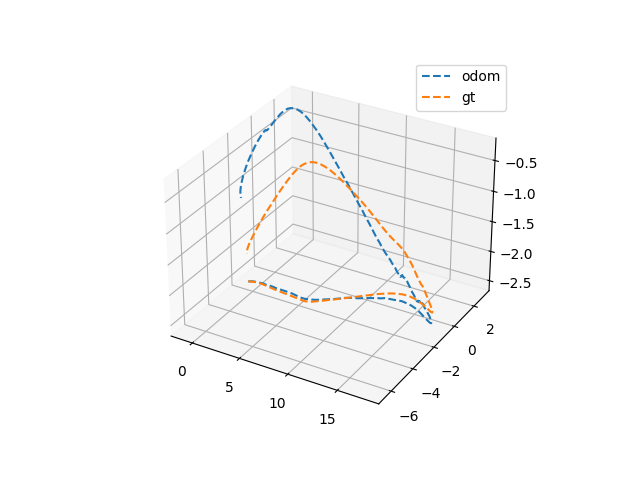

In [13]:

noisy_poses = dataset.add_noise(gt_poses[seq_start:], [3e-3, 5e-4], [3e-4, 3e-4], seed=100)
odom_poses = SE3([*gt_poses[:seq_start], *noisy_poses])
dataset.set_odometry(odom_poses)
dataset.set_ground_truth(gt_poses)

# for plotting
gt_traj = np.zeros((n_frames, 3))
odom_traj = np.zeros((n_frames, 3))

# add the odometry poses to the graph
for i in range(seq_start, seq_end):
    dataset.set_curr_index(i)
    gt_traj[i-seq_start] = dataset.read_current_ground_truth().t
    odom_traj[i-seq_start] = dataset.read_current_odometry().t

plt.clf()
ax = plt.figure().add_subplot(projection='3d')
ax.plot(odom_traj[:,0],odom_traj[:,1],odom_traj[:,2], '--', label='odom')
ax.plot(gt_traj[:,0],gt_traj[:,1],gt_traj[:,2], '--', label='gt')
ax.legend()
plt.show()

### 3. Add loop closure constraint

To add the loop closure constraint, we first need to detect the loop, which is usually done using a visual bag-of-words approach. This involves extracting features from each frame and then creating a dictionary of visual words to represent them. Then, we can match the visual words between frames to create a graph of similar frames, where each node represents a frame and edges represent similar frames.

Once we have detected the loop and found the relative pose between the start and end frame using algorithm like [PnP](https://docs.opencv.org/4.x/d5/d1f/calib3d_solvePnP.html), we can add a loop closure constraint to the pose graph optimization. As a result, the estimated trajectory will be much closer to the ground truth.

before optimizaiton error:  1867306.9592401008
after optimizaiton error:  0.0031986839078975856


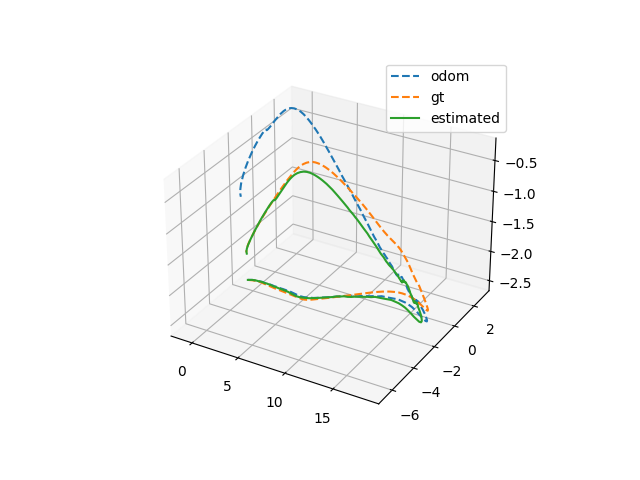

In [14]:
def to_gtsam_pose(pose):
    return gtsam.Pose3(gtsam.Rot3(pose.R), gtsam.Point3(pose.t))

# initialize the backend
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# add prior for the first pose
graph.push_back(gtsam.PriorFactorPose3(
    X(seq_start), to_gtsam_pose(odom_poses[seq_start]), gtsam.noiseModel.Diagonal.Sigmas(np.ones(6)*0.0001)
))
initial_estimate.insert(X(seq_start), to_gtsam_pose(odom_poses[seq_start]))

# for plotting
gt_traj = np.zeros((n_frames, 3))
odom_traj = np.zeros((n_frames, 3))

# add the odometry poses to the graph
for i in range(seq_start, seq_end):
    dataset.set_curr_index(i)
    gt_traj[i-seq_start] = dataset.read_current_ground_truth().t
    odom_traj[i-seq_start] = dataset.read_current_odometry().t
    initial_estimate.insert(X(i+1), to_gtsam_pose(odom_poses[i]))
    graph.push_back(gtsam.BetweenFactorPose3(
        X(i), X(i+1), to_gtsam_pose(odom_poses[i].inv()*odom_poses[i+1]),
        gtsam.noiseModel.Diagonal.Sigmas(np.ones(6)*0.5) # we set a higher noise for odometry
    ))

# add loop closures
graph.push_back(gtsam.BetweenFactorPose3(
    X(seq_end), X(seq_start), to_gtsam_pose(gt_poses[seq_end].inv()*gt_poses[seq_start]),
    gtsam.noiseModel.Diagonal.Sigmas(np.ones(6)*0.001)  # we set a lower noise for loop closure constraints
))

# optimize the graph
print('before optimizaiton error: ', graph.error(initial_estimate))
optimizer_params = gtsam.LevenbergMarquardtParams()
optimizer_params = gtsam.LevenbergMarquardtParams.CeresDefaults()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, optimizer_params)
current_estimate = optimizer.optimize()
estimated_traj = gtsam.utilities.extractPose3(current_estimate)[:, -3:]
print('after optimizaiton error: ', graph.error(current_estimate))

plt.clf()
ax = plt.figure().add_subplot(projection='3d')
ax.plot(odom_traj[:,0],odom_traj[:,1],odom_traj[:,2], '--', label='odom')
ax.plot(gt_traj[:,0],gt_traj[:,1],gt_traj[:,2], '--', label='gt')
ax.plot(estimated_traj[:,0],estimated_traj[:,1], estimated_traj[:,2], label='estimated')
ax.legend()
plt.show()

Congratulations! You have gained a solid understanding of the basic concepts and techniques used in real SLAM systems. By following the steps and examples we provided, you now have the knowledge to implement your own SLAM system in Python. Keep in mind that SLAM is a complex and evolving field, and there is always more to learn and explore. Don't hesitate to continue your learning journey and discover more advanced techniques and applications in SLAM.